In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)
processed_data = mrgy.reformat_gender_identity(processed_data)
df_gender = processed_data[processed_data['gender_identity'].isin(['Male', 'Female'])].dropna(subset=['rating'])

# treat rating as a categorical variable
df_gender['rating'] = df_gender['rating'].astype(str)

# theme for plots
sns.set_theme(style="whitegrid", font_scale=1.1)



# Question 4
What proportion of movies are rated differently by male and female viewers?


We now want to know how many movies show a statistically significant difference between male and female average ratings. 

The procedure to answer this question is as followed: 
1. Compare female and male 
2. Test their median and distributions 
3. Count number of movies such that p < 0.005
4. Divide by the total of movies to calculate the proportion.

In [2]:
df_gender.groupby('gender_identity')['rating'].describe()

,count,unique,top,freq
gender_identity,,,,
Female,32884,9,4.0,7178
Male,76765,9,4.0,18340


Text(0, 0.5, 'Proportion of Ratings')

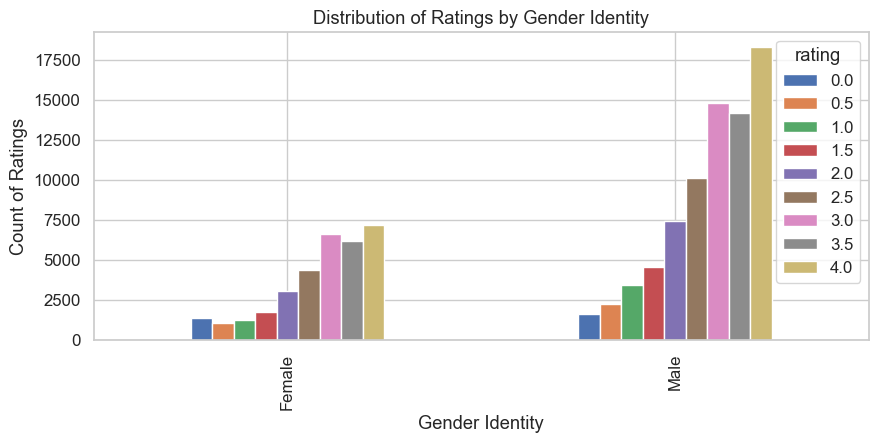

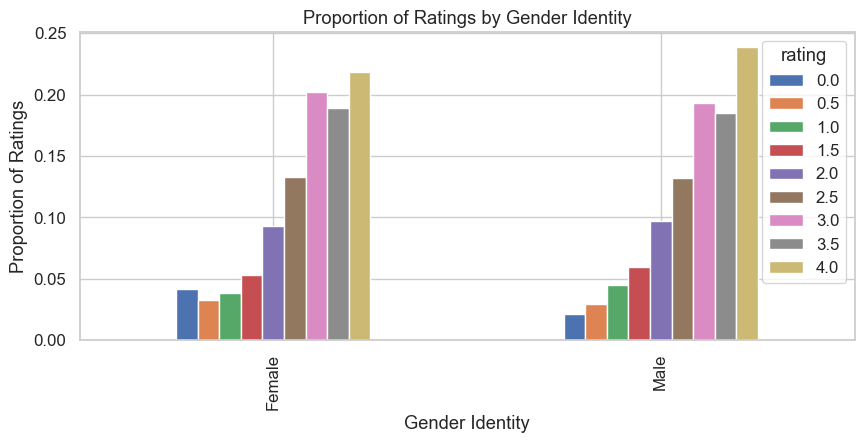

In [3]:
# get rating distributions
fig, axes = plt.subplots(1, 1, figsize=(10,4), sharey=True)
rating_counts = df_gender.groupby(['gender_identity', 'rating']).size().unstack(fill_value=0)
rating_counts.plot(kind='bar', stacked=False, ax=axes)
axes.set_title('Distribution of Ratings by Gender Identity')
axes.set_xlabel('Gender Identity')
axes.set_ylabel('Count of Ratings')

# get rating distrbution proportions
fig, axes = plt.subplots(1, 1, figsize=(10,4), sharey=True)
rating_props = rating_counts.div(rating_counts.sum(axis=1), axis=0)
rating_props.plot(kind='bar', stacked=False, ax=axes)
axes.set_title('Proportion of Ratings by Gender Identity')
axes.set_xlabel('Gender Identity')
axes.set_ylabel('Proportion of Ratings')  

In [33]:
def total_variation_distance(p, q):
    p, q = np.asarray(p, dtype=float), np.asarray(q, dtype=float)
    p, q = p / p.sum(), q / q.sum()
    return 0.5 * np.sum(np.abs(p - q))

In [45]:
df_gender_movie = df_gender.groupby(['movie_name'])
df_gender_movie.size()

n_movies = len(df_gender_movie)

results = pd.DataFrame(columns=['chi_p_value', 'dof', 'expected', 'jvd', 'mw_p_value', 'mw_u_stat'])

for name, group in df_gender_movie:
    movie_name = name
    # drop NA ratings
    ratings = group['rating'].dropna()
    
    # Split ratings by gender
    male_ratings = ratings[group['gender_identity'] == 'Male'].astype(float)
    female_ratings = ratings[group['gender_identity'] == 'Female'].astype(float)
    
    if len(male_ratings) > 0 and len(female_ratings) > 0:
        
        # check if ratings have na values
        if male_ratings.isna().sum() > 0 or female_ratings.isna().sum() > 0:
            print(f"NA values found in ratings for movie: {movie_name}")
            continue
        
        # Mann-Whitney U Test
        u_stat, p_value_mw = stats.mannwhitneyu(male_ratings, female_ratings, alternative='two-sided')
        
        # x^2 test
        contingency_table = pd.crosstab(group['gender_identity'], group['rating'])
        chi2, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)
        
        male = contingency_table.loc["Male"]
        female = contingency_table.loc["Female"]

        results.loc[movie_name] = [p_value_chi2, dof, expected, total_variation_distance(male, female), p_value_mw, u_stat]


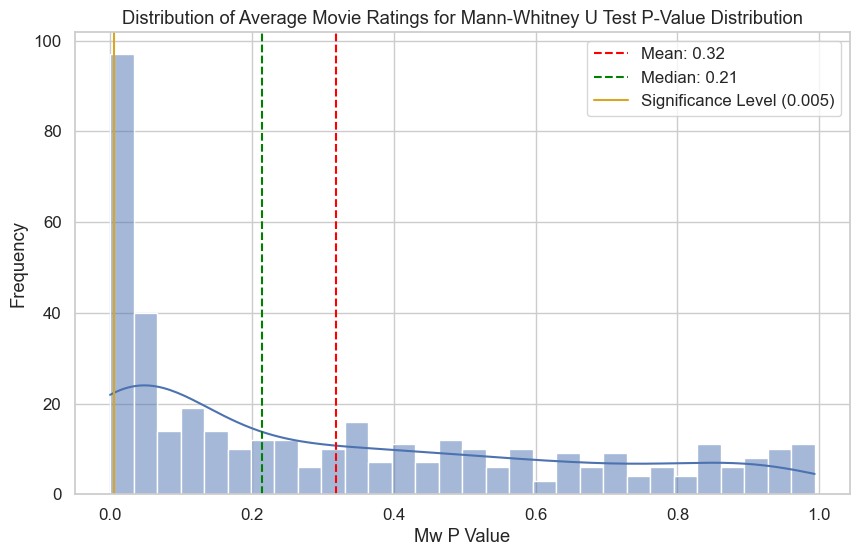

In [46]:
plt = gf.plot_distrubtion(results, 
    name='Mann-Whitney U Test P-Value Distribution', 
    y ='mw_p_value',
    show=False)

plt.axvline(x=0.005, color='goldenrod', linestyle='-', label='Significance Level (0.005)')
plt.legend()

plt.show()

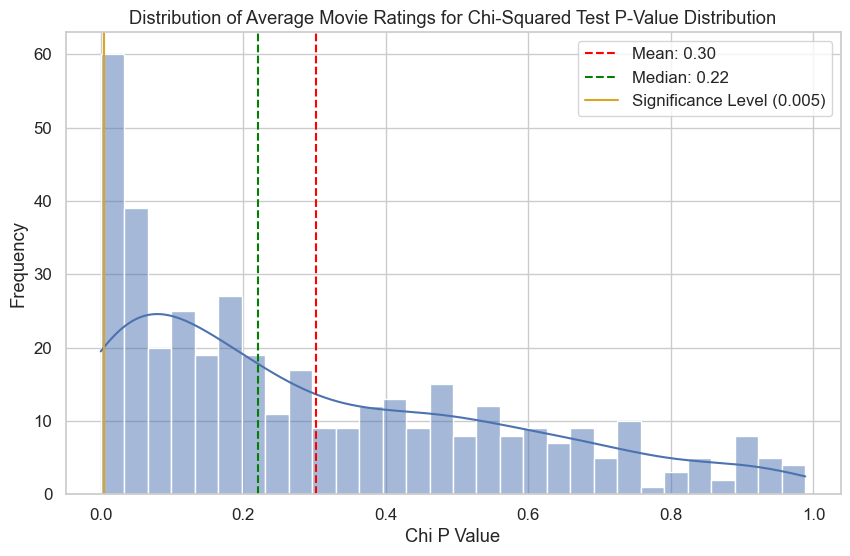

In [47]:
plt = gf.plot_distrubtion(results, 
    name='Chi-Squared Test P-Value Distribution', 
    y ='chi_p_value',
    show=False)

plt.axvline(x=0.005, color='goldenrod', linestyle='-', label='Significance Level (0.005)')
plt.legend()

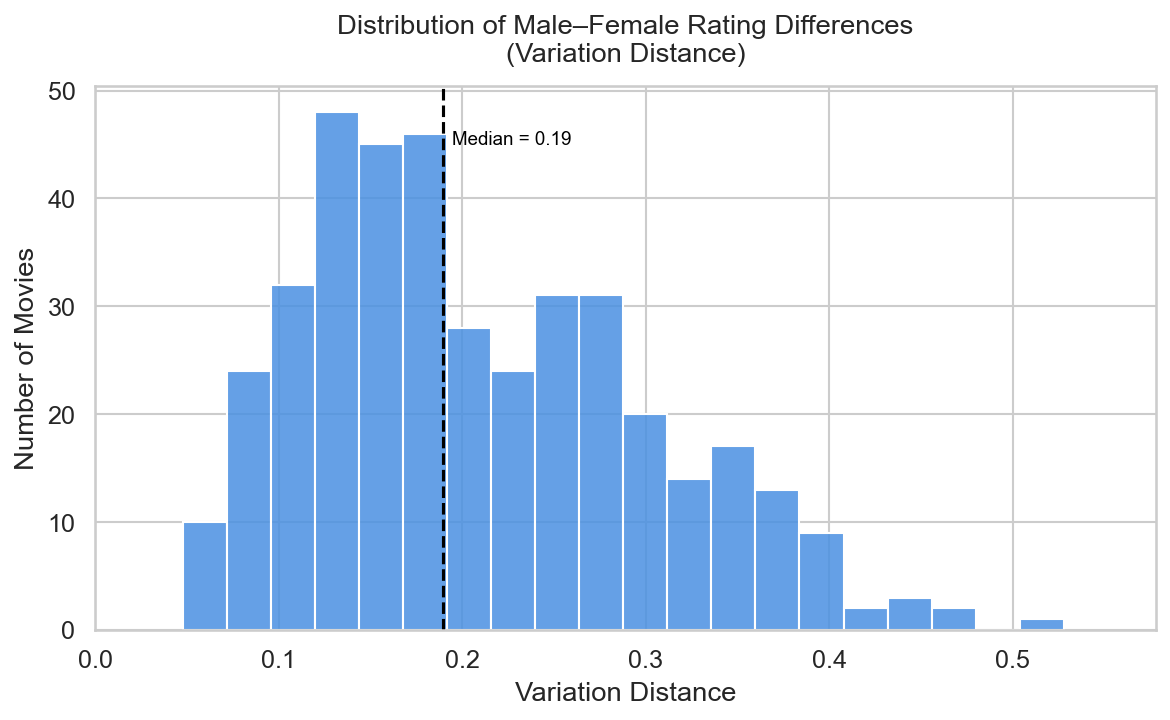

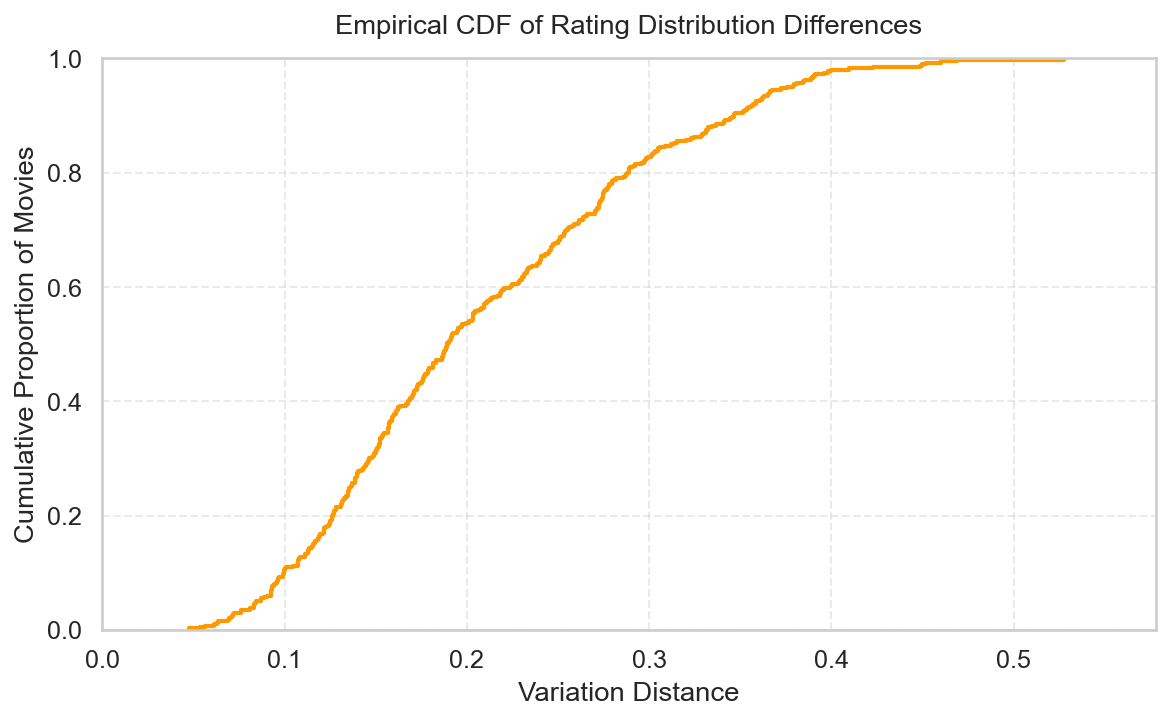

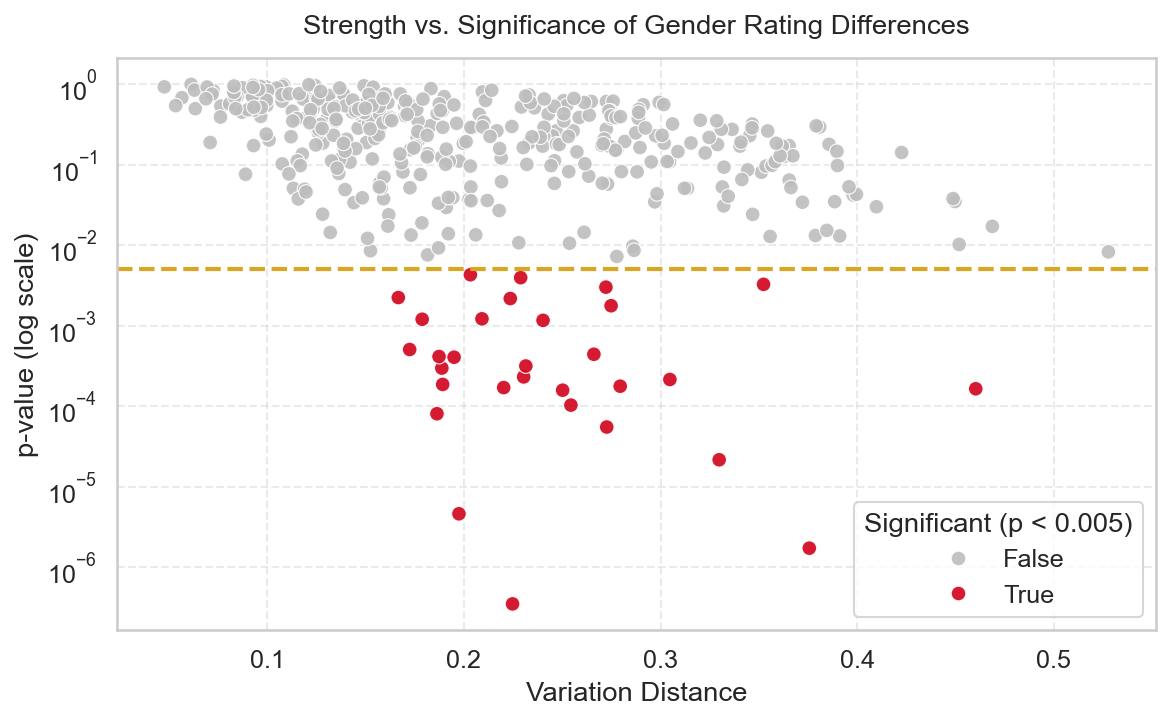

In [50]:

# Histogram
fig, ax = plt.subplots(figsize=(8,5), dpi=150)
sns.histplot(
    results["jvd"],
    bins=20,
    color="#4A90E2",
    edgecolor="white",
    alpha=0.85,
    ax=ax
)
ax.axvline(results["jvd"].median(), color="black", linestyle="--", lw=1.5)
ax.text(
    results["jvd"].median()+0.005, 45,
    f"Median = {results['jvd'].median():.2f}",
    fontsize=9, color="black"
)
ax.set_title("Distribution of Male–Female Rating Differences\n(Variation Distance)", pad=12)
ax.set_xlabel("Variation Distance")
ax.set_ylabel("Number of Movies")
ax.set_xlim(0, results["jvd"].max()+0.05)
plt.tight_layout()
plt.show()

# Empirical CDF
fig, ax = plt.subplots(figsize=(8,5), dpi=150)
sns.ecdfplot(
    results["jvd"],
    color="#FF9900",
    linewidth=2.0,
    ax=ax
)
ax.set_title("Empirical CDF of Rating Distribution Differences", pad=12)
ax.set_xlabel("Variation Distance")
ax.set_ylabel("Cumulative Proportion of Movies")
ax.set_xlim(0, results["jvd"].max()+0.05)
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Strength vs. Significance (log scale + thresholds)
fig, ax = plt.subplots(figsize=(8,5), dpi=150)
sns.scatterplot(
    data=results,
    x="jvd",
    y="chi_p_value",
    hue=results["chi_p_value"] < 0.005,
    palette={True:"#D0021B", False:"#BDBDBD"},
    alpha=0.9,
    s=50,
    ax=ax
)
ax.set_yscale("log")
ax.axhline(0.005, color='goldenrod', linestyle="--", lw=2)
ax.set_title("Strength vs. Significance of Gender Rating Differences", pad=12)
ax.set_xlabel("Variation Distance")
ax.set_ylabel("p-value (log scale)")
ax.legend(title="Significant (p < 0.005)", loc="lower right")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [62]:
# proportion of significant movies and effect sizes
proportion_chi2_significant = (results['chi_p_value'] < ALPHA).mean()
proportion_mw_significant = (results['mw_p_value'] < ALPHA).mean()


# make table 
# test1, test2
# number significant, number not significant

table_data = {
    'Test': ['Chi-Squared Test', 'Mann-Whitney U Test', 'Both Tests'],
    'Number Significant (p < 0.005)': [
        (results['chi_p_value'] < ALPHA).sum(),
        (results['mw_p_value'] < ALPHA).sum(),
        ((results['chi_p_value'] < ALPHA) & (results['mw_p_value'] < ALPHA)).sum()
    ],
    'Number Not Significant': [
        (results['chi_p_value'] >= ALPHA).sum(),
        (results['mw_p_value'] >= ALPHA).sum(),
        ((results['chi_p_value'] >= ALPHA) & (results['mw_p_value'] >= ALPHA)).sum()
    ],  
    'Proportion Significant': [
        proportion_chi2_significant,
        proportion_mw_significant,
        ((results['chi_p_value'] < ALPHA) & (results['mw_p_value'] < ALPHA)).mean()
    ],
    'Proportion Not Significant': [
        1 - proportion_chi2_significant,
        1 - proportion_mw_significant,
        ((results['chi_p_value'] >= ALPHA) & (results['mw_p_value'] >= ALPHA)).mean()
    ]
}

table_data_df = pd.DataFrame(table_data)
table_data_df

,Test,Number Significant (p < 0.005),Number Not Significant,Proportion Significant,Proportion Not Significant
0,Chi-Squared Test,30,370,0.0750,0.9250
1,Mann-Whitney U Test,50,350,0.1250,0.8750
2,Both Tests,29,349,0.0725,0.8725
